# Linear Regression Consulting Project

Congratulations! You've been contracted by Hyundai Heavy Industries to help them build a predictive model for some ships. [Hyundai Heavy Industries](http://www.hyundai.eu/en) is one of the world's largest ship manufacturing companies and builds cruise liners.

You've been flown to their headquarters in Ulsan, South Korea to help them give accurate estimates of how many crew members a ship will require.

They are currently building new ships for some customers and want you to create a model and use it to predict how many crew members the ships will need.

Here is what the data looks like so far:

    Description: Measurements of ship size, capacity, crew, and age for 158 cruise
    ships.


    Variables/Columns
    Ship Name     1-20
    Cruise Line   21-40
    Age (as of 2013)   46-48
    Tonnage (1000s of tons)   50-56
    passengers (100s)   58-64
    Length (100s of feet)  66-72
    Cabins  (100s)   74-80
    Passenger Density   82-88
    Crew  (100s)   90-96
    
It is saved in a csv file for you called "cruise_ship_info.csv". Your job is to create a regression model that will help predict how many crew members will be needed for future ships. The client also mentioned that they have found that particular cruise lines will differ in acceptable crew counts, so it is most likely an important feature to include in your analysis! 

Once you've created the model and tested it for a quick check on how well you can expect it to perform, make sure you take a look at why it performs so well!

In [0]:
table_name = "cruise_ship"
data = sqlContext.sql(f"SELECT * FROM {table_name}")
data = spark.createDataFrame(data.rdd)

data.show()
data.printSchema()

+-----------+-----------+---+------------------+------------------+-----------------+------------------+------------------+------------------+
|  Ship_name|Cruise_line|Age|           Tonnage|        passengers|           length|            cabins| passenger_density|              crew|
+-----------+-----------+---+------------------+------------------+-----------------+------------------+------------------+------------------+
|    Journey|    Azamara|  6|30.277000427246094| 6.940000057220459|5.940000057220459| 3.549999952316284| 42.63999938964844| 3.549999952316284|
|      Quest|    Azamara|  6|30.277000427246094| 6.940000057220459|5.940000057220459| 3.549999952316284| 42.63999938964844| 3.549999952316284|
|Celebration|   Carnival| 26|47.262001037597656|14.859999656677246| 7.21999979019165| 7.429999828338623|31.799999237060547| 6.699999809265137|
|   Conquest|   Carnival| 11|             110.0|29.739999771118164|9.529999732971191|14.880000114440918|  36.9900016784668|19.100000381469727|

## EDA

In [0]:
from pyspark.sql.functions import kurtosis, mean, sum, count, skewness, median, first, col
from pyspark.sql.functions import date_format, format_number


# age appears to be a string so we need to make it a float
data = data.withColumn('Age', col('Age').cast('float'))


summary_df = data.describe()


summary_df.select(

    'summary',
    'Ship_name',
    format_number(col('Age').cast('float'), 2).alias('age'),
    format_number(col('Tonnage').cast('float'), 2).alias('tonage'),
    format_number(col('passengers').cast('float'), 2).alias('passengers'),
    format_number(col('length').cast('float'), 2).alias('length'),
    format_number(col('cabins').cast('float'), 2).alias('cabins'),
    format_number(col('passenger_density').cast('float'), 2).alias('passenger_density'),
    'crew'

).show()

# # compute median
# df.approxQuantile('col_name', [0.5], 0)[0]

+-------+---------+------+------+----------+------+------+-----------------+------------------+
|summary|Ship_name|   age|tonage|passengers|length|cabins|passenger_density|              crew|
+-------+---------+------+------+----------+------+------+-----------------+------------------+
|  count|      158|158.00|158.00|    158.00|158.00|158.00|           158.00|               158|
|   mean| Infinity| 15.69| 71.28|     18.46|  8.13|  8.83|            39.90| 7.794177216065081|
| stddev|     null|  7.62| 37.23|      9.68|  1.79|  4.47|             8.64|3.5034866082349705|
|    min|Adventure|  4.00|  2.33|      0.66|  2.79|  0.33|            17.70|0.5899999737739563|
|    max|Zuiderdam| 48.00|220.00|     54.00| 11.82| 27.00|            71.43|              21.0|
+-------+---------+------+------+----------+------+------+-----------------+------------------+



In [0]:
# count all of the null values

for col_name in data.columns:
    null_count = data.filter(data[col_name].isNull()).count()
    print(f"Column {col_name} has {null_count} null values.")

Column Ship_name has 0 null values.
Column Cruise_line has 0 null values.
Column Age has 0 null values.
Column Tonnage has 0 null values.
Column passengers has 0 null values.
Column length has 0 null values.
Column cabins has 0 null values.
Column passenger_density has 0 null values.
Column crew has 0 null values.


In [0]:
# lets define some functions that will make the EDA simpler, incorperating visualisation and statistics between each of the 
# features with the target variable (crew)

# the continuous vs categorical function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway
from pyspark.sql.functions import col
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from scipy.stats import pearsonr
from pyspark.sql.functions import countDistinct

def continuous_vs_categorical(data_frame, continuous_col, categorical_col, plot_kind ='bar'):
    
    if plot_kind not in ['strip', 'swarm', 'box', 'violin', 'boxen', 'point', 'bar', 'count']:
        raise ValueError("plot_kind not one of 'strip', 'swarm', 'box', 'violin', 'boxen', 'point', 'bar', 'count'")
    # Check the number of unique categories in the categorical column
    num_categories = data_frame.select(categorical_col).distinct().count()
    
    # If there are only two categories, perform t-test
    if num_categories == 2:
        # Get data for each category
        category1_data = data_frame.filter(col(categorical_col) == 1).select(continuous_col).rdd.flatMap(lambda x: x).collect()
        category2_data = data_frame.filter(col(categorical_col) == 0).select(continuous_col).rdd.flatMap(lambda x: x).collect()
        
        # Perform t-test
        t_stat, p_value = ttest_ind(category1_data, category2_data)
        print("T-test statistic is {:.2f}, with p-value of {:.2f}".format(t_stat, p_value))
        
        # Create bar chart with error bars using Seaborn
        data = data_frame.select(categorical_col, continuous_col).toPandas()
        sns.catplot(x=continuous_col, y=categorical_col,
                    data=data, 
                    kind=plot_kind)
        plt.title("{} by {}".format(continuous_col, categorical_col))
        plt.show()
    
    # If there are more than two categories, perform ANOVA test
    elif num_categories > 2:
        # Get data for each category
        data_by_category = data_frame.groupBy(categorical_col).agg({continuous_col: 'collect_list'}).collect()
        category_data = [x[1] for x in data_by_category]
        
        # Perform ANOVA test
        f_stat, p_value = f_oneway(*category_data)
        print("ANOVA F-statistic is {:.2f}, with p-value of {:.2f}".format(f_stat, p_value))
        
        # Create bar chart with error bars using Seaborn
        data = data_frame.select(categorical_col, continuous_col).toPandas()

        sns.catplot(x=continuous_col, y=categorical_col,
                    data=data, 
                    kind=plot_kind)
        
        plt.title("{} by {}".format(continuous_col, categorical_col))
        plt.show()
        
    # If there are no categories, print error message
    else:
        print("Error: no categories found in categorical column")
        
        
        
        


# continuous vs continuous
def continuous_vs_continuous(data_frame, col1, col2):
    
    # Assemble the two columns into a vector
    assembler = VectorAssembler(inputCols=[col1, col2], outputCol="features")
    assembled_data = assembler.transform(data_frame)
    
    # Calculate the correlation coefficient and p-value
    data = assembled_data.select(col1, col2).toPandas()
    corr_coeff, p_value = pearsonr(data[col1], data[col2])
    print("Correlation coefficient between {} and {} is {:.2f} with p-value {:.2f}".format(col1, col2, corr_coeff, p_value))
    
    # Create scatter plot with regression line
    plt.figure(figsize=(10, 6))
    sns.regplot(data=data, x=col1, y=col2, line_kws={"color": "red"})
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title("{} vs. {}".format(col1, col2))
    plt.show()







    
# discrete variables

def discrete_comparison(df, col1, col2):
    """
    This function performs a comparison between two discrete variables in a DataFrame.
    It performs a chi-squared test and Cramer's V statistic to measure the strength of association
    between the two variables, and also plots a heat map to visualize the contingency table.
    :param df: DataFrame containing the data
    :param col1: Name of the first discrete column to compare
    :param col2: Name of the second discrete column to compare
    :return: None
    """
    # Create a contingency table of the two columns
    contingency_table = pd.crosstab(df[col1], df[col2])
    
    # Calculate chi-squared test statistic, p-value, degrees of freedom
    chi2, p, dof, _ = chi2_contingency(contingency_table)
    
    # Calculate Cramer's V statistic
    num_obs = np.sum(contingency_table.values)
    cramers_v = association(contingency_table.values)
    
    # Print results
    print(f"Chi-squared test statistic: {chi2:.2f}")
    print(f"P-value: {p:.2f}")
    print(f"Degrees of freedom: {dof}")
    print(f"Cramer's V statistic: {cramers_v:.2f}")
    
    # Plot a heat map of the contingency table
    sns.heatmap(contingency_table, annot=True, cmap="Blues")
    
    
    
    


def detect_datatype_and_plot(df, figsize=(10, 8)):
    # Loop through each column in the dataframe
    for column in df.columns:
        # Check if the column is numeric (continuous)
        if df.select(column).dtypes[0][1] in ['int', 'bigint', 'float', 'double']:
            # If it's numeric, plot a KDE/histogram
            plt.figure(figsize=figsize)
            sns.histplot(data=df.toPandas(), x=column, kde=True)
            plt.show()
        else:
            # If it's not numeric, count the distinct values and plot a bar chart
            distinct_count = df.select(countDistinct(col(column))).collect()[0][0]
            if distinct_count < 10:
                # For columns with fewer than 10 distinct values, use a bar chart
                plt.figure(figsize=figsize)
                sns.countplot(data=df.toPandas(), x=column, order=df.toPandas()[column].value_counts().index)
                plt.show()
            else:
                # For columns with more than 10 distinct values, use a horizontal bar chart
                plt.figure(figsize=(figsize[0], distinct_count / 2))
                sns.countplot(data=df.toPandas(), y=column, order=df.toPandas()[column].value_counts().index)
                plt.show()






In [0]:
data.columns

Out[70]: ['Cruise_line',
 'Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
 'crew']

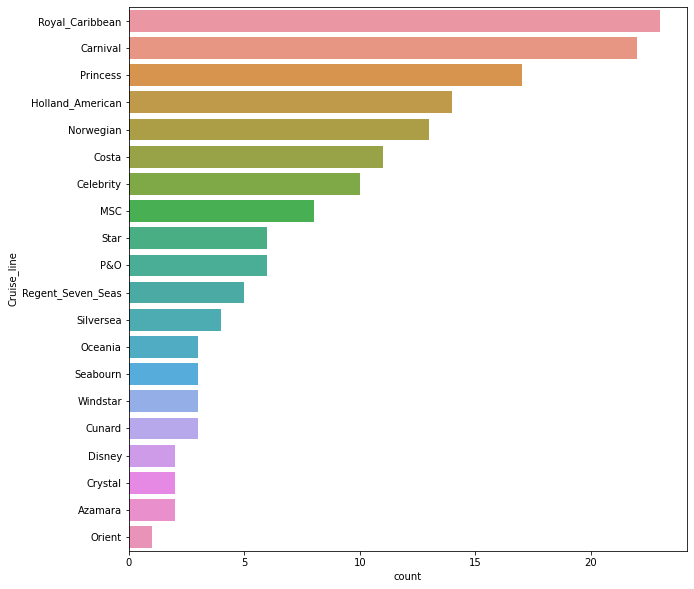

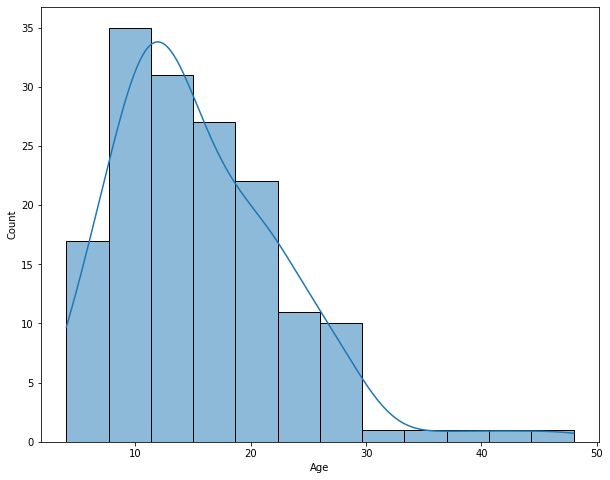

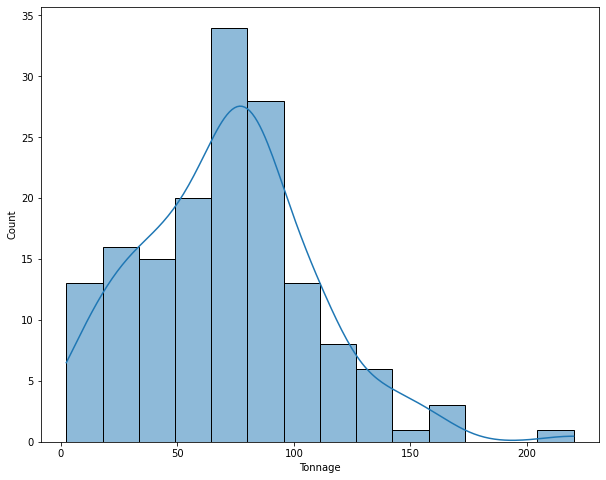

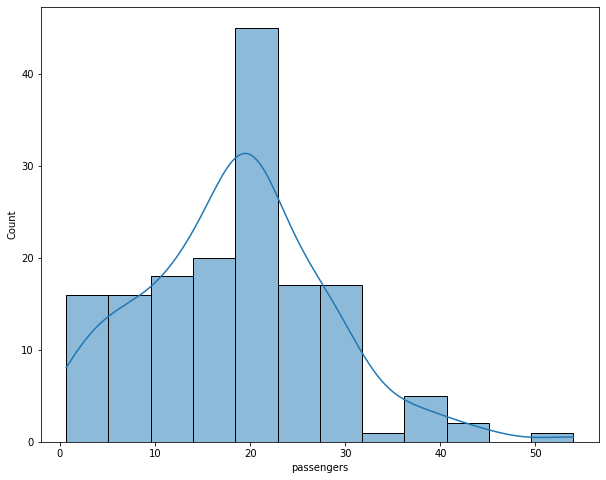

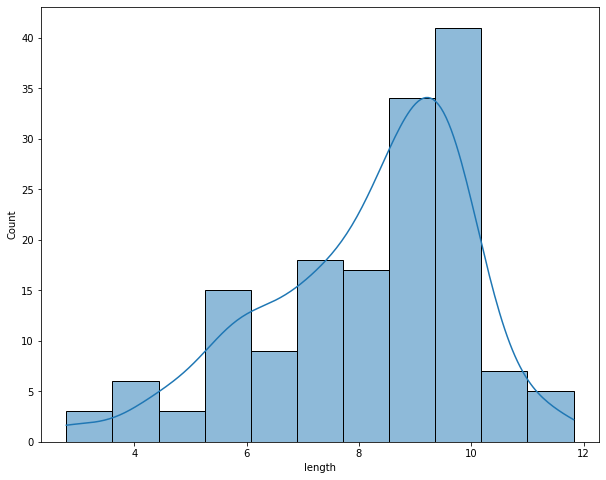

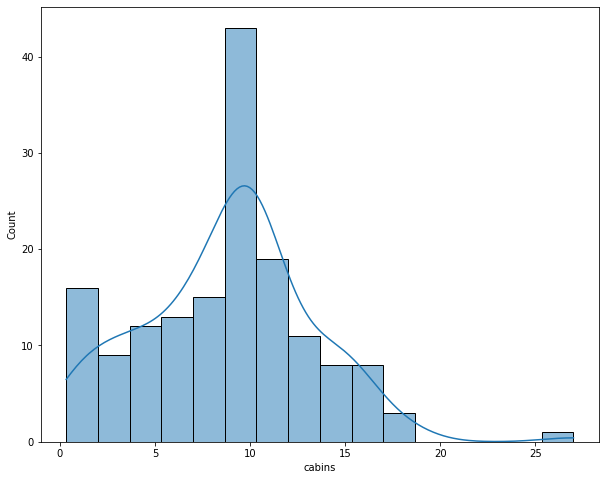

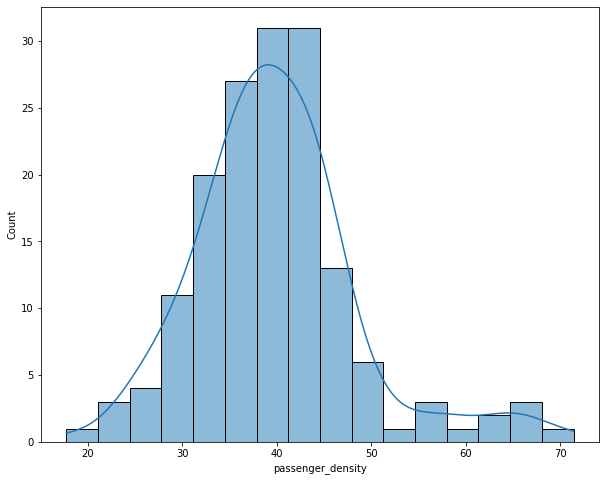

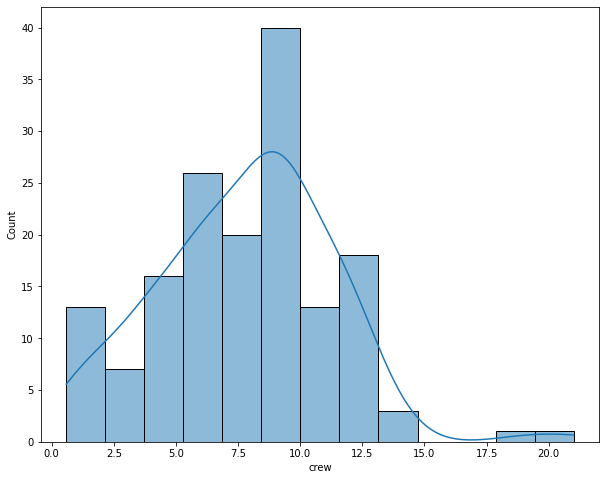

In [0]:
# lets take a look at distribution

detect_datatype_and_plot(data)

You can see the continuous features all follow some normal-ish distribution, so fitting a linear regression is appropriate and there is no need for normalising the distribution with log transformations

Correlation coefficient between crew and Age is -0.53 with p-value 0.00


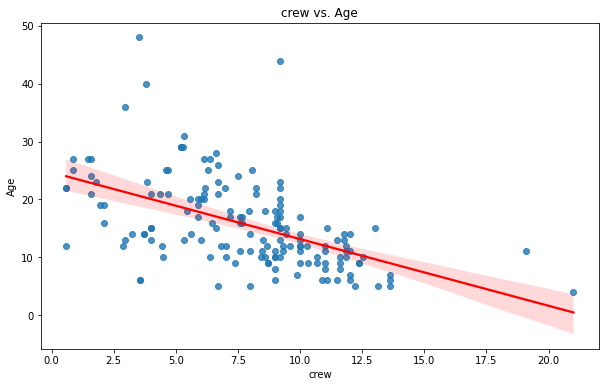




Correlation coefficient between crew and Tonnage is 0.93 with p-value 0.00


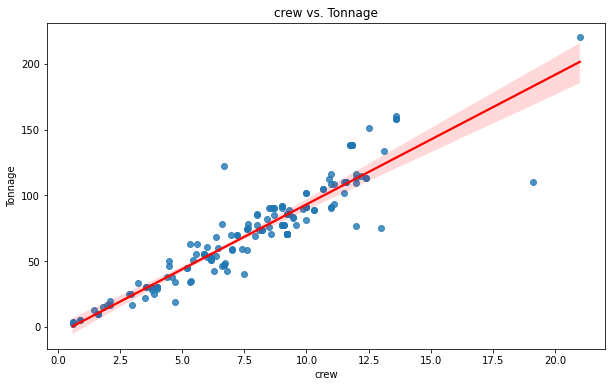




Correlation coefficient between crew and passengers is 0.92 with p-value 0.00


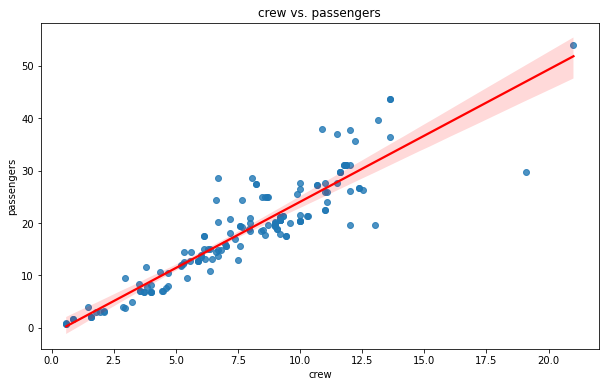




Correlation coefficient between crew and length is 0.90 with p-value 0.00


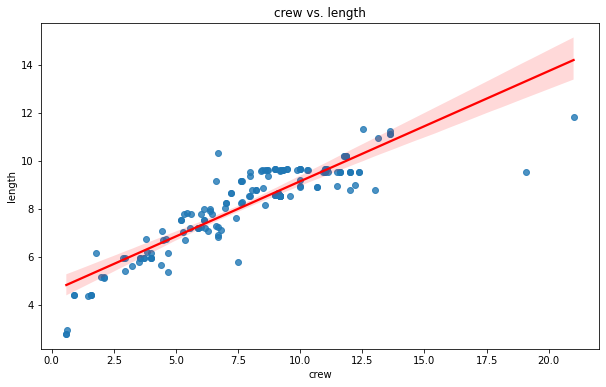




Correlation coefficient between crew and cabins is 0.95 with p-value 0.00


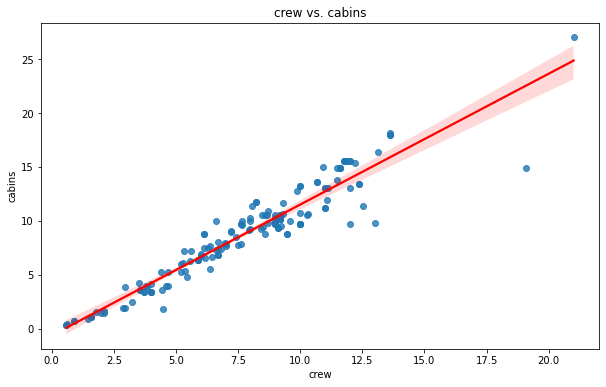




Correlation coefficient between crew and passenger_density is -0.16 with p-value 0.05


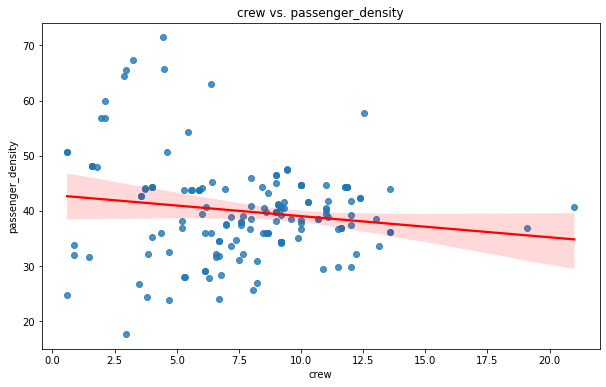

In [0]:
for cont_feature in ['Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density']:
    
    continuous_vs_continuous(data, 'crew', cont_feature)
    print('\n\n')

ANOVA F-statistic is 7.01, with p-value of 0.00


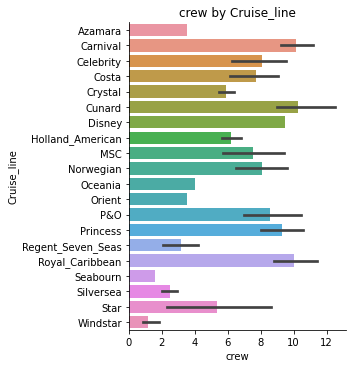

In [0]:
# what about the cruise line vs number of crew?

continuous_vs_categorical(data, categorical_col = 'Cruise_line', continuous_col = 'crew')

In [0]:
# variance inflation factor between the varibles
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif_calculate(data.select()):
    
    data = data.toPandas()
    
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    vif["features"] = data.columns
    
    return vif



  File <command-4050969543187489>:4
    def vif_calculate(data.select()):
                          ^
SyntaxError: invalid syntax


In [0]:
vif = vif_calculate(data.select('Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
 'crew'))
vif

,VIF Factor,features
0,7.516309,Age
1,94.521240,Tonnage
2,142.554118,passengers
3,110.673990,length
4,194.712663,cabins
5,26.131233,passenger_density
6,79.046837,crew


From what I can see all of the features belong in a model that can predict the crew, with possibly the exception of passenger density that lies on the 95% pvalue boundary for correlation. Two models could be made, one with and one without this feature.

VIF scores also indicate potential for high amount of multicollinearity between the feature variables

## Preprocessing

In [0]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression

In [0]:

## Here is an example of what each preprocessing step looks like

# # drop the ship name col
# data = data.drop("Ship_name")


# # train test split
# train_data, test_data = data.randomSplit([0.8, 0.2])

# # Index categorical column 'Cruise_line'
# indexer = StringIndexer(inputCol="Cruise_line", outputCol="Cruise_line_indexed")
# data_index = indexer.fit(train_data).transform(train_data)

# data_index.show()

# # One-hot encode categorical column 'Cruise_line'
# encoder = OneHotEncoder(inputCol="Cruise_line_indexed", outputCol="Cruise_line_encoded")
# encode_data = encoder.fit(data_index).transform(data_index)

# encode_data.show()

# # # Standard scale continuous columns ['Age', 'Tonnage', 'passengers', 'length', 'cabins', 'passenger_density']
# scaled_assembler = VectorAssembler(inputCols=['Age', 'Tonnage', 'passengers', 'length', 'cabins', 'passenger_density'], outputCol='cont_features')
# scaler = StandardScaler(inputCol='cont_features', outputCol='scaled_features', withMean=True, withStd=True)
# scaled_data = scaled_assembler.transform(encode_data)
# scaled_data = scaler.fit(scaled_data).transform(scaled_data)

# scaled_data.show()


# # Combine encoded and scaled continuous features
# assembler_features = VectorAssembler(inputCols=["Cruise_line_encoded", "scaled_features"], outputCol="features")
# full_train_data = assembler_features.transform(scaled_data)



# # Final dataset
# full_train_data.select('features', 'crew').show()



In [0]:
# pipeline version of the preprocessing steps, I have included the vector assembler for the cateogrical features to show
# what the code would look like for multiple categorical features

# train test split
train_data, test_data = data.randomSplit([0.8, 0.2])

# Define the names of the categorical and continuous features
cat_cols = ['Cruise_line']
cont_cols = ['Age', 'Tonnage', 'passengers', 'length', 'cabins', 'passenger_density']

# Create a pipeline to preprocess the data

# Create a pipeline to preprocess the data
# categorical
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(data) for column in cat_cols]
encoders = [OneHotEncoder(inputCol=column+"_index", outputCol=column+"_encoded") for column in cat_cols]
assembler_cat = VectorAssembler(inputCols = [column+"_encoded" for column in cat_cols], outputCol = 'cat_features')


# continuous
assembler_cont = VectorAssembler(inputCols=cont_cols, outputCol="cont_features")
scaler = StandardScaler(inputCol="cont_features", outputCol="scaled_features")
assembler_all = VectorAssembler(inputCols=["cat_features", "scaled_features"], outputCol="features")

# pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler_cat, assembler_cont, scaler, assembler_all])

# Fit the pipeline to the data
pipelineModel = pipeline.fit(train_data)

# Transform the data
preprocessed_train_data = pipelineModel.transform(train_data)
preprocessed_test_data = pipelineModel.transform(test_data)

# show the datasets
preprocessed_train_data.show()
preprocessed_test_data.show()

+-----------+----+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+-------------------+---------------+--------------------+--------------------+--------------------+
|Cruise_line| Age|           Tonnage|        passengers|           length|            cabins| passenger_density|              crew|Cruise_line_index|Cruise_line_encoded|   cat_features|       cont_features|     scaled_features|            features|
+-----------+----+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+-------------------+---------------+--------------------+--------------------+--------------------+
|    Azamara| 6.0|30.277000427246094| 6.940000057220459|5.940000057220459| 3.549999952316284| 42.63999938964844| 3.549999952316284|             16.0|    (19,[16],[1.0])|(19,[16],[1.0])|[6.0,30.277000427...|[0.88010218883818...|(25,[16,19,20,21,...|
|   

In [0]:
# descriptions

preprocessed_train_data.describe().show()
preprocessed_test_data.describe().show()

+-------+-----------+-----------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+
|summary|Cruise_line|              Age|           Tonnage|        passengers|            length|             cabins| passenger_density|              crew|Cruise_line_index|
+-------+-----------+-----------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+
|  count|        128|              128|               128|               128|               128|                128|               128|               128|              128|
|   mean|       null|       15.6640625| 69.33208559453487|18.083359413780272| 8.054062489420176|  8.677421893225983|39.946953013539314| 7.664453130681068|        4.9921875|
| stddev|       null|6.817390157750408|34.851607793217404| 9.362734364349349|1.7260475308394356| 4.3165696550629375| 8.968314049637494|

## Modelling

In [0]:
# fit the simple linear regression

lr = LinearRegression(featuresCol="features", labelCol="crew", predictionCol="predicted_crew_count")

lr_model = lr.fit(preprocessed_train_data)

test_results = lr_model.evaluate(preprocessed_test_data)
train_results = lr_model.evaluate(preprocessed_train_data)

print(train_results.r2, lr_model.summary.r2 , '\n', train_results.rootMeanSquaredError)
print(test_results.r2, test_results.rootMeanSquaredError)

0.9384080526910938 0.9384080526910938 
 0.8402645796677075
0.9693119876679139 0.6772932859533715


In [0]:
data.select('crew').describe().show()

+-------+------------------+
|summary|              crew|
+-------+------------------+
|  count|               158|
|   mean| 7.794177216065081|
| stddev|3.5034866082349705|
|    min|0.5899999737739563|
|    max|              21.0|
+-------+------------------+



You can see above we have performed better on the test set than the training set and generally the model has a low RMSE compared to the original data since a standard deviation is 3.5

This is an indication that the model isnt complex enough and that there are other data sources that could contribute to the accuracy (explain the variance)